# Проект для «Ниединогоразрыва.ком»

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

 **Цель работы**: подготовить данные для обучения и тестирования модели. Подобрать лучшую модель по метрике на кросс-валидации для прогнозирования оттока клиентов.

**План работы данной части:**
1. Объединить датасеты, избавиться от ненужных признаков и, возможно, создать новые на основе имеющихся. Создать таргет на основе столбца EndDate. No будет означать, что пользователь не ушле (0), а дата будет означать, что пользователь покинул компании (1). Т.е. данные заменятся на 0 и 1 соответсвенно. Также рассчитать корреляцию признаков конечной таблицы и избавиться от тех, у которых коэффициент корреляции очень высок.
2. Разделить выборку на тренировочную и тестовую в соотношнии 3 к 1.
3. Закодировать категориальные признаки и провести (в зависимости от распредления) нормализацию или стандартизацию данных.
2. Обучить модели (LGBM, логистической регресии и catboost) на тренировочной выборке. Подберем лучшие гиперпараметры на валидационной выборке. Сравним с константной моделью по roc-кривым.
3. Выберем наилучшую модель по метрике auc-roc на кросс-валидации и получим предсказания на тестовой выборке.

In [ ]:
import warnings

import numpy as np
import pandas as pd
import os
import seaborn as sns
import scipy.stats as ss
import random
import math
import matplotlib.pyplot as plt

from numpy.random import RandomState
from pandas.plotting import scatter_matrix
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler,StandardScaler
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from scipy import stats

RANDOM_STATE = RandomState(30723)
warnings.filterwarnings("ignore")

In [ ]:
!pip install scikit-learn==1.2.0

## Исследовательская часть

In [ ]:
def get_dataset(path):
    if os.path.exists(path):
        data = pd.read_csv(path, index_col=0)
    elif os.path.exists(f'/datasets/{path}'):
        data = pd.read_csv(f'/datasets/{path}', index_col=0)
    else:
        print('Something is wrong')
    return data

In [ ]:
def draw_barplot(dataset, columns,figsize_h, figsize_w, count_rows=2):
    ncols= math.ceil(len(columns)/count_rows)
    fig, axs = plt.subplots(nrows=count_rows,ncols=ncols,figsize=(figsize_h, figsize_w))
    col, row = 0, 0
    for i in range(len(columns)):
        #print(col,row)
        if col >= ncols:
            col = 0
            row += 1
        sns.countplot(data=dataset, x='is_close', hue=columns[i], ax=axs[row, col])
        axs[row, col].set_title(columns[i])
        axs[row, col].set_ylabel('Количество')
        axs[row, col].set_xlabel('Покинули')
        axs[row, col].legend(loc='upper right')
        col += 1

    fig.tight_layout(w_pad=10)
    plt.show()

In [ ]:
def yes_no_to_boolean(dataset, *column):
    for col in column:
        dataset.replace({col:{ 'No' : 0 , 'Yes' : 1 }}, inplace=True)
        dataset[col] = pd.to_numeric(arg=dataset[col], downcast='integer', errors='coerce')

In [ ]:
def proportion(data, column, variant):
    q3 = data[column].quantile(0.75)
    q1 = data[column].quantile(0.25)
    IQR = q3 - q1
    if variant == 1:
        print('Доля: ', data.loc[data[column] >= q3 + 1.5*IQR][column].count() / data[column].count())
    elif variant == 2:
        print('Доля: ', data.loc[data[column] <= q1 - 1.5*IQR][column].count() / data[column].count())
    elif variant == 3:
        print('Доля: ', (data.loc[data[column] <= q1 - 1.5*IQR][column].count()+data.loc[data[column] >= q3 + 1.5*IQR][column].count())
      / data[column].count())
    else:
        print('Неправильно переданы данные')

In [ ]:
data_contract = get_dataset('contract_new.csv')
data_internet_services = get_dataset('internet_new.csv')
data_personal = get_dataset('personal_new.csv')
data_phone_services = get_dataset('phone_new.csv')

In [ ]:
data_contract['BeginDate']=pd.to_datetime(data_contract['BeginDate'], format='%Y-%m-%d', errors='coerce')
data_contract['TotalCharges'] =pd.to_numeric(arg=data_contract['TotalCharges'], errors='coerce')

In [ ]:
data_contract[data_contract['TotalCharges'].isnull()]

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN


In [ ]:
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7032 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 440.2+ KB


In [ ]:
data_contract['TotalCharges'] = data_contract['TotalCharges'].fillna(data_contract['MonthlyCharges'])
data_contract['TotalCharges'].isna().sum()

0

In [ ]:
yes_no_to_boolean(data_contract, 'PaperlessBilling' )

In [ ]:
yes_no_to_boolean(data_internet_services, 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',\
                 'StreamingTV', 'StreamingMovies')

In [ ]:
yes_no_to_boolean(data_personal, 'Partner', 'Dependents' )

In [ ]:
yes_no_to_boolean(data_phone_services, 'MultipleLines' )


## Подготовка данных

Объединим таблицы в одну.

In [ ]:
full_data = data_contract.merge(data_internet_services, left_index = True,  right_index = True, how='outer')

In [ ]:
full_data = full_data.merge(data_personal, left_index = True,  right_index = True, how='outer')

In [ ]:
full_data = full_data.merge(data_phone_services,left_index = True,  right_index = True, how='outer')

In [ ]:
full_data.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
0002-ORFBO,2019-05-01,No,One year,1,Mailed check,65.6,631.73,DSL,0.0,1.0,0.0,1.0,1.0,0.0,Female,0,1,1,0.0
0003-MKNFE,2019-05-01,No,Month-to-month,0,Mailed check,59.9,539.10,DSL,0.0,0.0,0.0,0.0,0.0,1.0,Male,0,0,0,1.0
0004-TLHLJ,2019-09-01,No,Month-to-month,1,Electronic check,73.9,406.45,Fiber optic,0.0,0.0,1.0,0.0,0.0,0.0,Male,0,0,0,0.0
0011-IGKFF,2018-12-01,No,Month-to-month,1,Electronic check,98.0,1372.00,Fiber optic,0.0,1.0,1.0,0.0,1.0,1.0,Male,1,1,0,0.0
0013-EXCHZ,2019-09-01,No,Month-to-month,1,Mailed check,83.9,444.67,Fiber optic,0.0,0.0,0.0,1.0,1.0,0.0,Female,1,1,0,0.0


In [ ]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0002-ORFBO to 9995-HOTOH
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   int8          
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   InternetService   5517 non-null   object        
 8   OnlineSecurity    5517 non-null   float64       
 9   OnlineBackup      5517 non-null   float64       
 10  DeviceProtection  5517 non-null   float64       
 11  TechSupport       5517 non-null   float64       
 12  StreamingTV       5517 non-null   float64       
 13  StreamingMovies   5517 non-null   float64       
 14  gender        

### Обработка пропусков

In [ ]:
full_data.isna().sum()

BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
dtype: int64

Заметим, что при объединение столбцов возникли пропуски. Посмотим на них.

In [ ]:
full_data[full_data.isna().any(axis=1)]

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
0017-DINOC,2015-08-01,No,Two year,0,Credit card (automatic),45.20,2611.66,DSL,1.0,0.0,0.0,1.0,1.0,0.0,Male,0,0,0,NaN
0019-GFNTW,2015-06-01,2020-01-01,Two year,0,Bank transfer (automatic),45.05,2651.19,DSL,1.0,1.0,1.0,1.0,0.0,0.0,Female,0,0,0,NaN
0020-JDNXP,2017-04-01,No,One year,0,Mailed check,61.25,2082.50,DSL,1.0,0.0,1.0,1.0,1.0,1.0,Female,0,1,1,NaN
0023-HGHWL,2019-10-01,No,Month-to-month,1,Electronic check,25.10,100.40,DSL,0.0,0.0,0.0,0.0,0.0,0.0,Male,1,0,0,NaN
0023-UYUPN,2015-12-01,No,One year,0,Electronic check,25.20,1348.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,1,1,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9972-EWRJS,2014-07-01,No,Two year,1,Bank transfer (automatic),19.25,1289.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Female,0,1,1,0.0
9975-GPKZU,2016-04-01,No,Two year,0,Credit card (automatic),19.75,908.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,1,1,0.0
9975-SKRNR,2020-01-01,No,Month-to-month,0,Mailed check,18.90,20.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Male,0,0,0,0.0


Пропусков оказалось довольно много, как и было сказанно выше, они возникли при объединении таблиц. В таблицах, содержащих столбцы, в которых присутсвуют пропуски, отсутствовали некоторые клиенты (индексы). Так как данные клиенты отсутствовали в таблицах, можно предположить, что ни одна из услуг у них не была подключена. Можем заменить все пропуски на 0. А пропуски в столбце InternetService заменим на строку 'none'.


In [ ]:
full_data['InternetService'] = full_data['InternetService'].fillna('note')

In [ ]:
full_data=full_data.fillna(0)

In [ ]:
full_data.isna().sum()

BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
dtype: int64

### Распределение и выбросы


Посмотрим далее на распределение данных, чтобы подобрать подходящий метод подсчета корреляции.

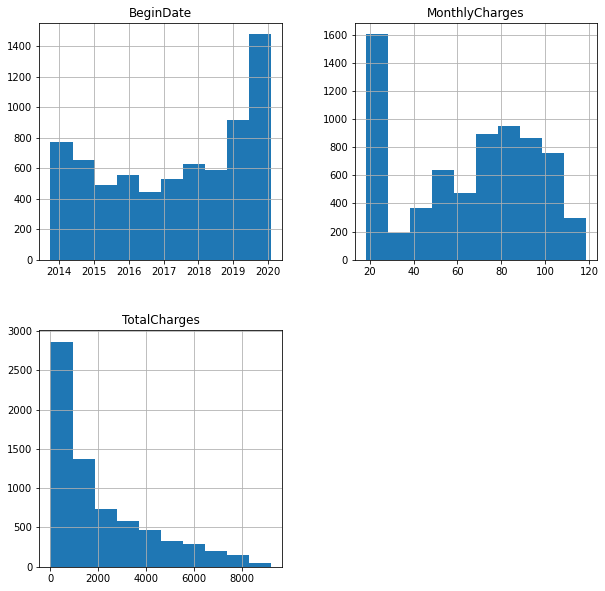

In [ ]:
plt.rcParams['figure.figsize']=(10,10)
full_data[['BeginDate', 'MonthlyCharges', 'TotalCharges']].hist()

plt.show()

Заметим, что распределение численных признаков отличается от нормального. По данному признаку можно предположить, что для масштабирования данных лучше будет использовать нормализацию данных.

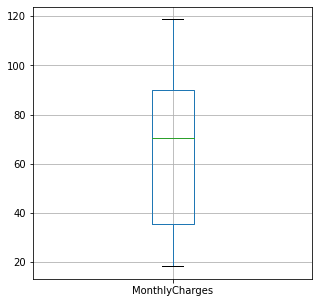

In [ ]:
#full_data[['BeginDate', 'MonthlyCharges', 'TotalCharges']].boxplot()
plt.rcParams['figure.figsize']=(5,5)
full_data[['MonthlyCharges']].boxplot()
plt.show()

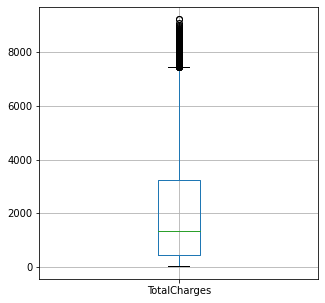

In [ ]:
full_data[['TotalCharges']].boxplot()
plt.show()

В признаке TotalCharges присутсвуют выбросы. Посмотрим сколько их в соотношении ко всем данным.

In [ ]:
proportion(full_data, 'TotalCharges', 1)

Доля:  0.027687065171091863


Больше 2% от всех данных, самих данных не очень много, поэтому удаление будет не уместным.

### Дополнительное исследовние к прошлой части

Посмотрим на распределение значений времени пользования услугами ушедшими пользователями.

In [ ]:
data_departed_users = full_data.loc[full_data['EndDate'] != 'No']

In [ ]:
data_departed_users['EndDate'] = pd.to_datetime(data_departed_users['EndDate'],format='%Y-%m-%d', errors='coerce')
data_departed_users['time_before_go'] = (data_departed_users['EndDate']-data_departed_users['BeginDate']).dt.days
data_departed_users['time_before_go'] = pd.to_numeric(data_departed_users['time_before_go'])

In [ ]:
data_departed_users['time_before_go']

customerID
0019-GFNTW    1675
0022-TCJCI      92
0040-HALCW     213
0042-RLHYP    1007
0064-YIJGF     669
              ... 
9948-YPTDG     881
9950-MTGYX     335
9968-FFVVH     700
9972-VAFJJ     973
9992-RRAMN     212
Name: time_before_go, Length: 1101, dtype: int64

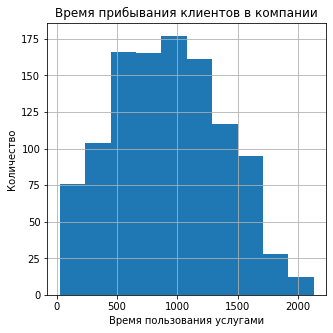

In [ ]:
data_departed_users['time_before_go'].hist()
plt.title('Время прибывания клиентов в компании')
plt.ylabel('Количество')
plt.xlabel('Время пользования услугами')
plt.show()

Из этой гистограммы видно, что в среднем клиенты уходят через 1000 день, что ровняется примерно 2.7 годам.

### Создание новых признаков

Так как у нас присутвуют признаки, содержашие в себе метку даты начала контракта и окончания, тогда создадим новый информативный признак - длителность контракта. Для этого в признаки EndDate удалим заменим все пропуски на дату выгрузки данных (1 февраля 2020), а затем возьмем разницу в днях между окончанием контракта и началом.

In [ ]:
full_data.replace({'EndDate':{ 'No' : '2020-02-01'}}, inplace=True)
full_data['EndDate'] = pd.to_datetime(full_data['EndDate'],format='%Y-%m-%d', errors='coerce')

In [ ]:
full_data['EndDate']

customerID
0002-ORFBO   2020-02-01
0003-MKNFE   2020-02-01
0004-TLHLJ   2020-02-01
0011-IGKFF   2020-02-01
0013-EXCHZ   2020-02-01
                ...    
9987-LUTYD   2020-02-01
9992-RRAMN   2018-09-01
9992-UJOEL   2020-02-01
9993-LHIEB   2020-02-01
9995-HOTOH   2020-02-01
Name: EndDate, Length: 7043, dtype: datetime64[ns]

In [ ]:
full_data['con_duration'] = (full_data['EndDate']-full_data['BeginDate']).dt.days

In [ ]:
full_data['con_duration']

customerID
0002-ORFBO     276
0003-MKNFE     276
0004-TLHLJ     153
0011-IGKFF     427
0013-EXCHZ     153
              ... 
9987-LUTYD     396
9992-RRAMN     212
9992-UJOEL      62
9993-LHIEB    2041
9995-HOTOH    1918
Name: con_duration, Length: 7043, dtype: int64

### Объеденим столбцы в списки для удобства

In [ ]:
bool_columns = ['PaperlessBilling', 'OnlineSecurity','OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines', 'is_close']
numeric_columns = ['BeginDate', 'MonthlyCharges', 'TotalCharges','con_duration', 'EndDate']
categ_columns = ['Type', 'PaymentMethod', 'InternetService', 'gender']

### Создание таргета

Создадим таргетовый признак. Он будет создан из столбца EndDate, из которого значения No будут соотвествовать 0, а какая-то дата - 1.

In [ ]:
full_data['is_close'] = np.where(full_data['EndDate']=='2020-02-01', 0, 1)
#full_data = full_data.drop(columns = ['EndDate'],axis = 1)
full_data

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,...,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,con_duration,is_close
customerID,,,,,,,,,,,,,,,,,,,,,
0002-ORFBO,2019-05-01,2020-02-01,One year,1,Mailed check,65.60,631.73,DSL,0.0,1.0,...,1.0,1.0,0.0,Female,0,1,1,0.0,276,0
0003-MKNFE,2019-05-01,2020-02-01,Month-to-month,0,Mailed check,59.90,539.10,DSL,0.0,0.0,...,0.0,0.0,1.0,Male,0,0,0,1.0,276,0
0004-TLHLJ,2019-09-01,2020-02-01,Month-to-month,1,Electronic check,73.90,406.45,Fiber optic,0.0,0.0,...,0.0,0.0,0.0,Male,0,0,0,0.0,153,0
0011-IGKFF,2018-12-01,2020-02-01,Month-to-month,1,Electronic check,98.00,1372.00,Fiber optic,0.0,1.0,...,0.0,1.0,1.0,Male,1,1,0,0.0,427,0
0013-EXCHZ,2019-09-01,2020-02-01,Month-to-month,1,Mailed check,83.90,444.67,Fiber optic,0.0,0.0,...,1.0,1.0,0.0,Female,1,1,0,0.0,153,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9987-LUTYD,2019-01-01,2020-02-01,One year,0,Mailed check,55.15,724.12,DSL,1.0,0.0,...,1.0,0.0,0.0,Female,0,0,0,0.0,396,0
9992-RRAMN,2018-02-01,2018-09-01,Month-to-month,1,Electronic check,85.10,595.70,Fiber optic,0.0,0.0,...,0.0,0.0,1.0,Male,0,1,0,1.0,212,1
9992-UJOEL,2019-12-01,2020-02-01,Month-to-month,1,Mailed check,50.30,102.61,DSL,0.0,1.0,...,0.0,0.0,0.0,Male,0,0,0,0.0,62,0


### Корреляция

Так как признаки, содержащие количественные данные, имеют не нормальное распределение, тогда для подсчета корреляции воспользуемся методом Спирмена.

In [ ]:
full_data[numeric_columns].corr(method='spearman')

,MonthlyCharges,TotalCharges,con_duration
MonthlyCharges,1.000000,0.646556,0.253513
TotalCharges,0.646556,1.000000,0.877275
con_duration,0.253513,0.877275,1.000000


Корреляция между 'MonthlyCharges' и 'TotalCharges' признаками присутсвует, очевидно, что это возможно из-за того, что конечная сумма складывается из месячных платежей.

<div class="alert alert-info"> Очень высокая зависимость con_duration и TotalCharges. Данная зависимость возникла, так как продолжительность контракта и общая сумма платежей имеют связь, ведь чем дольше пользователь явялется клиентом, тем больше тсановится его общий платеж. Удалим столбец TotalCharges.</div>

In [ ]:
full_data = full_data.drop('TotalCharges', axis=1)

Посмотрим на связь между категориальными признаками с помощью корреляции V Пирсона.

In [ ]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [ ]:
rows= []
for var1 in full_data[[*categ_columns, *bool_columns]]:
    col = []
    for var2 in full_data[[*categ_columns, *bool_columns]] :
        cramers =cramers_v(full_data[var1], full_data[var2])
        col.append(round(cramers,2))
    rows.append(col)

cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns = [*categ_columns, *bool_columns], index=[*categ_columns, *bool_columns])

df

,Type,PaymentMethod,InternetService,gender,PaperlessBilling,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,SeniorCitizen,Partner,Dependents,MultipleLines,is_close
Type,1.00,0.27,0.21,0.00,0.18,0.25,0.16,0.23,0.30,0.11,0.12,0.14,0.30,0.24,0.11,0.16
PaymentMethod,0.27,1.00,0.31,0.00,0.25,0.17,0.19,0.20,0.18,0.25,0.25,0.19,0.16,0.15,0.23,0.14
InternetService,0.21,0.31,1.00,0.00,0.38,0.39,0.38,0.38,0.39,0.44,0.44,0.26,0.00,0.18,0.37,0.09
gender,0.00,0.00,0.00,1.00,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
PaperlessBilling,0.18,0.25,0.38,0.00,1.00,0.00,0.13,0.10,0.04,0.22,0.21,0.16,0.01,0.11,0.16,0.05
OnlineSecurity,0.25,0.17,0.39,0.01,0.00,1.00,0.28,0.27,0.35,0.18,0.19,0.04,0.14,0.08,0.10,0.08
OnlineBackup,0.16,0.19,0.38,0.01,0.13,0.28,1.00,0.30,0.29,0.28,0.27,0.07,0.14,0.02,0.20,0.15
DeviceProtection,0.23,0.20,0.38,0.00,0.10,0.27,0.30,1.00,0.33,0.39,0.40,0.06,0.15,0.01,0.20,0.14
TechSupport,0.30,0.18,0.39,0.00,0.04,0.35,0.29,0.33,1.00,0.28,0.28,0.06,0.12,0.06,0.10,0.07
StreamingTV,0.11,0.25,0.44,0.00,0.22,0.18,0.28,0.39,0.28,1.00,0.53,0.10,0.12,0.01,0.26,0.13


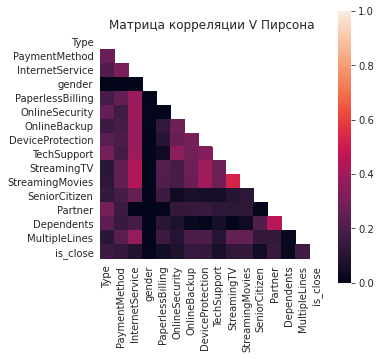

In [ ]:
mask = np.zeros_like(df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(df, mask=mask,vmin=0., vmax=1, square=True)

plt.title('Матрица корреляции V Пирсона')
plt.show()

Корреляция между категориальными признаками также невысока. Также в данной матрице можно рассмотреть влияние признаков на нашу целевую переменную - is_close. Влияние категориальных признаков на целевую переменную очень незначительно. Почти никакого влияния как на целевое значение, так и на другие признаки не играет признак "Gender".

Выше мы уже смотрели на распредления численных признаков, теперь посмотрим в зависимости от целевой переменной is_close

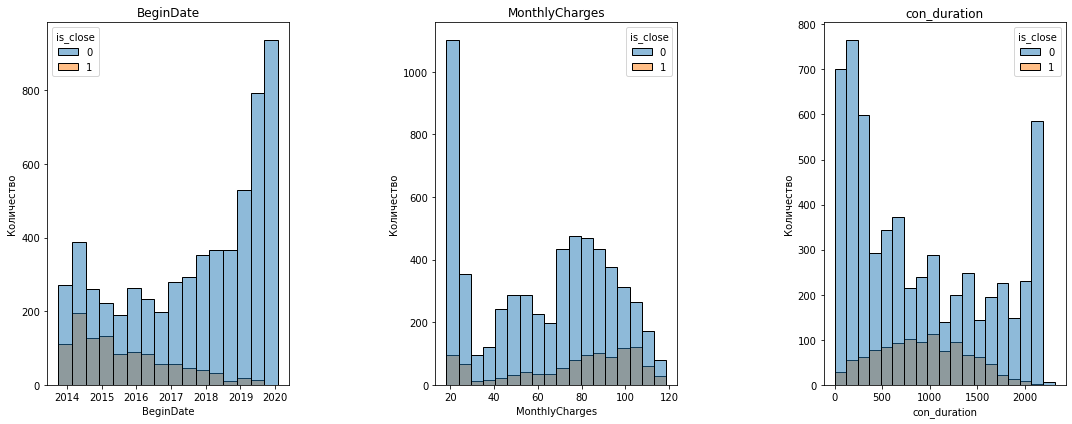

In [ ]:
columns = ['BeginDate', 'MonthlyCharges', 'con_duration']
fig, axs = plt.subplots(ncols=3,figsize=(15, 6))
for i in range(len(columns)):
    sns.histplot(data=full_data, x=columns[i], hue='is_close', ax=axs[i], stat='count')
    axs[i].set_title(columns[i])
    axs[i].set_ylabel('Количество')
    #axs[i].set_xlabel('Покинули')

fig.tight_layout(w_pad=10)
plt.show()

Распределения оплаты по месяцам у клиентов, которые ушли и которые остались, в целом не отличаются.

Как было показано чуть ранне в среднем клиенты пользуются услугами компании около 1000 дней.

Постепенно все меньше людей в соотношение с кол-вом новых пользователей покидают компанию.

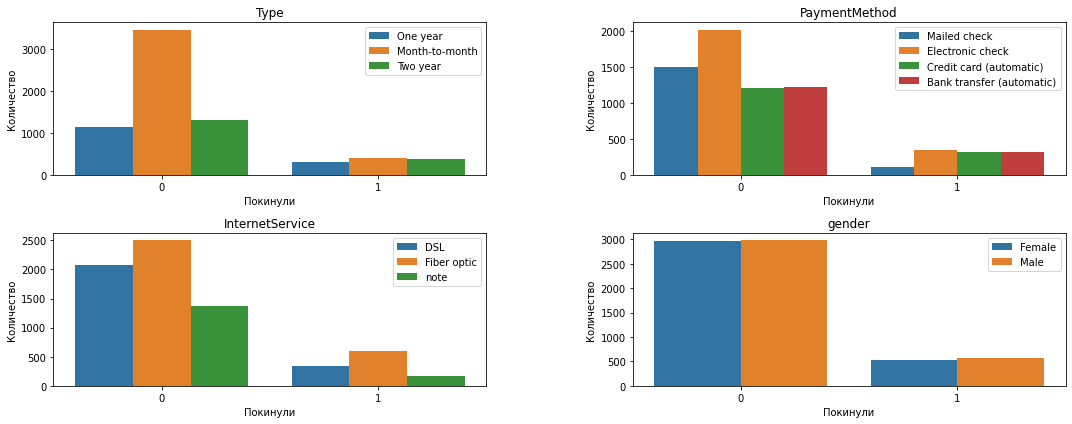

In [ ]:
draw_barplot(full_data, categ_columns, 15, 6)

Как и было подечено в прошлой часте пользователи, которые заключают контракт по тарифу оплаты по месяцам уходят совсем немного чаще, чем те, кто заключает на год или два. Но также мы можем заметить, что тариф оплата по месяцам пользуется намного большей популярностью, чем другие тарифы.

Нет зависимости ухода пользователей от их пола.

Примерно в одинаковом соотношении уходят пользователи, которые получают чеки любым способом кроме почты.

В целом сохраняется соотношение между способом подключения к интернету (или его отсутвию) у пользователей, которые покинули компании и которые остались.



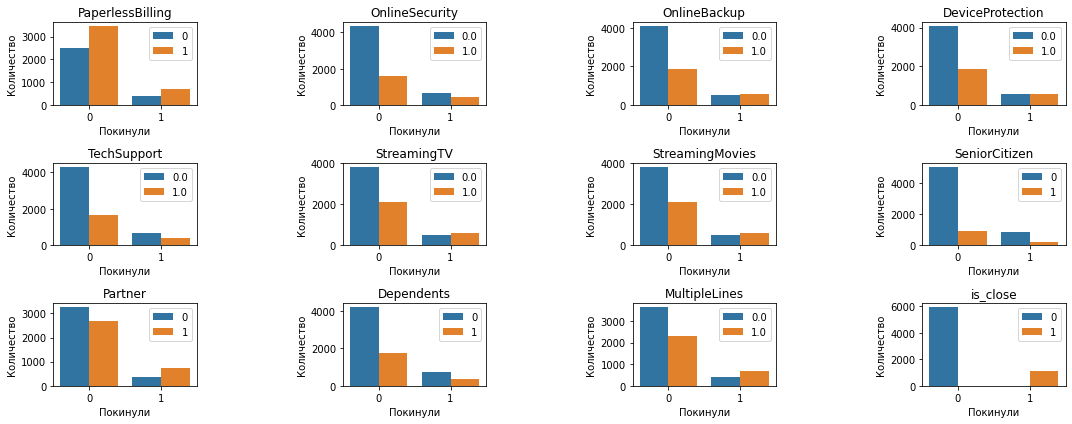

In [ ]:
draw_barplot(full_data, bool_columns, 15, 6, 3)

Стриминговыми сервисами пользуются примерно одна треть всех пользователей, которые остались в компании. Подключение в виде оптоволоконна имеет немного большую популярность. Примерно в два раза меньше людей пользуются блокировкой небезопасных сайтов и выделенной технической линией. Аналогичным дело обстоит с облачым хранилищем и антивирусом.

Зато распредление допольнительных услгу пользователей, которое покинули компанию, отличаются от тех, которые остались. Либо в равном соотношении, либо немного в большинстве покидают те, у которых были подключены какие-либо услуги. Исключения это - выделенная линия тех. поддержки, гражданин, блокировка небез. сайтов, у них ситуация соответсвуют с распределением оставшихся пользователей. Например, отличается также распределение наличие или отсутвие партнера между пользователями, которые остались и ушли. Чаще уходят пользователи, которые состоят в отношениях. Также распределение столбцов "пенсионер" и "иждевенец" у оставшихся и покинувших компании пользователей не отличаются.

Также в последнем окне можем заметить распределение ушел пользователь или остался. Посмотрим на него поближе

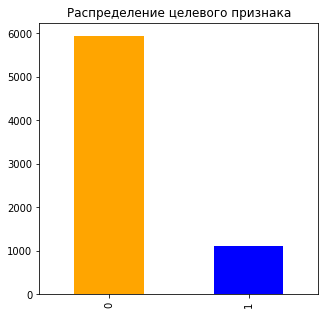

In [ ]:
full_data['is_close'].value_counts().plot(kind='bar', color=['orange', 'blue'])
plt.title('Распределение целевого признака')
plt.show()

Присутствует дисбаланас классов, но так как дальше мы будем использоват метрику auc-roc, мы не будем решать проблему дисбаланса.

### Удаление ненужных признаков

In [ ]:
full_data = full_data.drop('BeginDate', axis = 1)
full_data = full_data.drop('EndDate', axis = 1)
full_data.columns

Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines',
       'con_duration', 'is_close'],
      dtype='object')

### Переименование столбцов

In [ ]:
full_data.columns=full_data.columns.str.lower()
full_data = full_data.rename(columns={'paperlessbilling': 'paperless_billing', 'paymentmethod':'payment_method',\
                                     'monthlycharges':'monthly_charges', 'totalcharges':'total_charges', \
                                     'internetservice':'internet_service', 'onlinesecurity':'online_security',\
                                     'onlinebackup':'online_backup', 'deviceprotection':'device_protection',\
                                     'techsupport':'tech_support', 'streamingtv':'streaming_tv',\
                                     'streamingmovies':'streaming_movies', 'seniorcitizen':'senior_citizen'})

In [ ]:
full_data.columns


Index(['type', 'paperless_billing', 'payment_method', 'monthly_charges',
       'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',
       'gender', 'senior_citizen', 'partner', 'dependents', 'multiplelines',
       'con_duration', 'is_close'],
      dtype='object')

После удаления и переименования некоторых признаков обновим списки столбцов

In [ ]:
numeric_columns = ['monthly_charges', 'con_duration']
bool_columns = ['paperless_billing', 'online_security', 'online_backup',\
       'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies',\
       'senior_citizen', 'partner', 'dependents', 'multiplelines']
categ_columns = full_data.select_dtypes(include=['object']).columns

In [ ]:
for col in bool_columns:
    full_data[col]=pd.to_numeric(arg=full_data[col], downcast='integer')

In [ ]:
full_data[bool_columns].info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0002-ORFBO to 9995-HOTOH
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   paperless_billing  7043 non-null   int8 
 1   online_security    7043 non-null   int8 
 2   online_backup      7043 non-null   int8 
 3   device_protection  7043 non-null   int8 
 4   tech_support       7043 non-null   int8 
 5   streaming_tv       7043 non-null   int8 
 6   streaming_movies   7043 non-null   int8 
 7   senior_citizen     7043 non-null   int8 
 8   partner            7043 non-null   int8 
 9   dependents         7043 non-null   int8 
 10  multiplelines      7043 non-null   int8 
dtypes: int8(11)
memory usage: 388.7+ KB


In [ ]:
full_data.reset_index(drop= True , inplace= True )

## Модель

In [ ]:
features_train, features_test, y_train, y_test = train_test_split(full_data.drop(columns='is_close'), full_data['is_close'], test_size=0.25,
                                                    random_state=RANDOM_STATE, stratify=full_data['is_close'])

<div class="alert alert-info"> Проверим, сохранилось ли соотношение целевого признака у получившихся выборок<div>

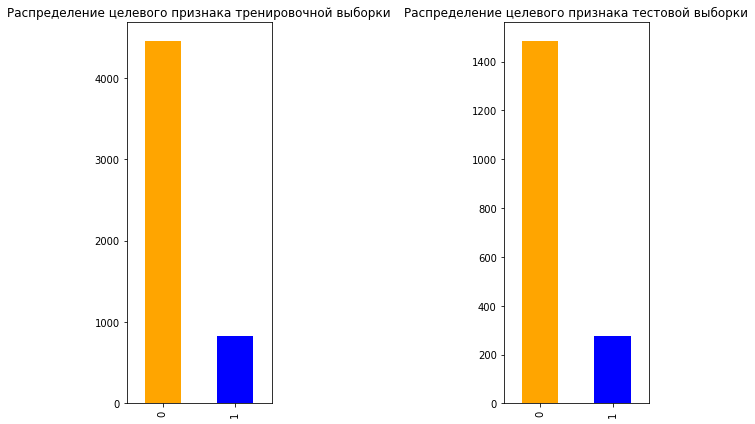

In [ ]:
fig, axs = plt.subplots(ncols=2,figsize=(8, 6))
y_train.value_counts().plot(kind='bar', color=['orange', 'blue'], ax=axs[0])
axs[0].set_title('Распределение целевого признака тренировочной выборки')

y_test.value_counts().plot(kind='bar', color=['orange', 'blue'], ax=axs[1])
axs[1].set_title('Распределение целевого признака тестовой выборки')
fig.tight_layout(w_pad=20)
plt.show()

Соотношение целевого признака сохранилось

In [ ]:
model_result={}

In [ ]:
num_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])

cat_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='error', drop='first'))])


preprocessor_with_transform = ColumnTransformer(transformers=[('num', num_transformer, numeric_columns),
                                               ('cat', cat_transformer, categ_columns)], remainder='passthrough')

preprocessor_no_transform = ColumnTransformer(transformers=[('num', num_transformer, numeric_columns)])


pipe_logistic = Pipeline(steps=[('preprocessor', preprocessor_with_transform),
                       ('classifier', LogisticRegression(random_state=RANDOM_STATE))])
pipe_LGBM = Pipeline(steps=[('preprocessor', preprocessor_with_transform),
                       ('classifier', LGBMClassifier(random_state=RANDOM_STATE))])
pipe_Cat = Pipeline(steps=[('preprocessor', preprocessor_with_transform),
                       ('classifier', CatBoostClassifier(random_state=30723))])

search_space_catboosting={
                                    "classifier__n_estimators": range(100, 500, 100),
                                    #"classifier__num_leaves": [2**1, 2**2, 2**3, 2**4, 2**5],
                                    "classifier__learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.3, 1.0],
                                    #"classifier__cat_features": ['type', 'payment_method', 'internet_service', 'gender'],

                        },
search_space_lgbmboosting={
                                    "classifier__n_estimators": range(100, 500, 100),
                                    "classifier__num_leaves": [2**1, 2**2, 2**3, 2**4, 2**5],
                                    "classifier__learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.3, 1.0]
                        },
search_space={
                                   "classifier__C": [0.001,0.01,0.1,1,10,100],
                                   'classifier__max_iter':[100,150,200],
                                   'classifier__solver':['liblinear']
                        },

In [ ]:
grid_search = GridSearchCV(pipe_logistic, search_space, cv=4, scoring={'auc':'roc_auc', 'acc':'accuracy'}, return_train_score=False, n_jobs=-1, refit='auc', verbose=3)
model_result['LogisticRegression'] = grid_search.fit(features_train, y_train)

Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV 1/4] END classifier__C=0.001, classifier__max_iter=100, classifier__solver=liblinear; acc: (test=0.843) auc: (test=0.350) total time=   0.0s
[CV 2/4] END classifier__C=0.001, classifier__max_iter=100, classifier__solver=liblinear; acc: (test=0.843) auc: (test=0.401) total time=   0.2s
[CV 3/4] END classifier__C=0.001, classifier__max_iter=100, classifier__solver=liblinear; acc: (test=0.844) auc: (test=0.432) total time=   0.3s
[CV 4/4] END classifier__C=0.001, classifier__max_iter=100, classifier__solver=liblinear; acc: (test=0.844) auc: (test=0.371) total time=   0.2s
[CV 1/4] END classifier__C=0.001, classifier__max_iter=150, classifier__solver=liblinear; acc: (test=0.843) auc: (test=0.350) total time=   0.2s
[CV 2/4] END classifier__C=0.001, classifier__max_iter=150, classifier__solver=liblinear; acc: (test=0.843) auc: (test=0.401) total time=   0.2s
[CV 3/4] END classifier__C=0.001, classifier__max_iter=150, classifie

In [ ]:
search_space_boosting = GridSearchCV(pipe_LGBM, search_space_lgbmboosting, cv=4, scoring={'auc':'roc_auc', 'acc':'accuracy'}, return_train_score=False, n_jobs=-1, refit='auc', verbose=3)
model_result['GridSearchCV'] = grid_search.fit(features_train, y_train)

Fitting 4 folds for each of 18 candidates, totalling 72 fits
[CV 1/4] END classifier__C=0.001, classifier__max_iter=100, classifier__solver=liblinear; acc: (test=0.843) auc: (test=0.350) total time=   0.1s
[CV 2/4] END classifier__C=0.001, classifier__max_iter=100, classifier__solver=liblinear; acc: (test=0.843) auc: (test=0.401) total time=   0.2s
[CV 3/4] END classifier__C=0.001, classifier__max_iter=100, classifier__solver=liblinear; acc: (test=0.844) auc: (test=0.432) total time=   0.3s
[CV 4/4] END classifier__C=0.001, classifier__max_iter=100, classifier__solver=liblinear; acc: (test=0.844) auc: (test=0.371) total time=   0.2s
[CV 1/4] END classifier__C=0.001, classifier__max_iter=150, classifier__solver=liblinear; acc: (test=0.843) auc: (test=0.350) total time=   0.2s
[CV 2/4] END classifier__C=0.001, classifier__max_iter=150, classifier__solver=liblinear; acc: (test=0.843) auc: (test=0.401) total time=   0.2s
[CV 3/4] END classifier__C=0.001, classifier__max_iter=150, classifie

In [ ]:
grid_search = GridSearchCV(pipe_Cat, search_space_catboosting, cv=4, scoring={'auc':'roc_auc', 'acc':'accuracy'}, return_train_score=False, n_jobs=-1, refit='auc', verbose=3)
model_result['CatBoostClassifier'] = grid_search.fit(features_train, y_train)

Fitting 4 folds for each of 24 candidates, totalling 96 fits
0:	learn: 0.6930603	total: 48.1ms	remaining: 4.76s
1:	learn: 0.6929812	total: 50.1ms	remaining: 2.46s
2:	learn: 0.6929008	total: 52.1ms	remaining: 1.68s
3:	learn: 0.6928122	total: 53.9ms	remaining: 1.29s
4:	learn: 0.6927244	total: 55.6ms	remaining: 1.06s
5:	learn: 0.6926342	total: 57.4ms	remaining: 899ms
6:	learn: 0.6925460	total: 59.1ms	remaining: 785ms
7:	learn: 0.6924653	total: 60.8ms	remaining: 699ms
8:	learn: 0.6923786	total: 62.4ms	remaining: 631ms
9:	learn: 0.6923011	total: 64.1ms	remaining: 577ms
10:	learn: 0.6922318	total: 65.8ms	remaining: 532ms
11:	learn: 0.6921516	total: 67.5ms	remaining: 495ms
12:	learn: 0.6920744	total: 69.3ms	remaining: 464ms
13:	learn: 0.6919852	total: 71ms	remaining: 436ms
14:	learn: 0.6919038	total: 72.7ms	remaining: 412ms
15:	learn: 0.6918162	total: 74.5ms	remaining: 391ms
16:	learn: 0.6917249	total: 76.2ms	remaining: 372ms
17:	learn: 0.6916427	total: 77.9ms	remaining: 355ms
18:	learn: 0.69

In [ ]:
for key in model_result.keys():
    print(f'{key}: auc-roc: {model_result[key].best_score_}, accuracy: {model_result[key].cv_results_["mean_test_auc"][-1]}' )


LogisticRegression: auc-roc: 0.7534259437492912, accuracy: 0.7534259437492912
GridSearchCV: auc-roc: 0.7534259437492912, accuracy: 0.7534259437492912
CatBoostClassifier: auc-roc: 0.9006983989158791, accuracy: 0.8718282786620553


По метрике auc-roc лучший результат показала модель catboost

In [ ]:
print(model_result['CatBoostClassifier'].best_params_)

{'classifier__learning_rate': 0.1, 'classifier__n_estimators': 400}


С помощью GridSearchCV была найдена лучшая модель по метрике AUC-ROC со следующими гиперпарамтерами:

модель: CatBoostClassifier

learning_rate=0.1

кол-во деревьев: 400

Стоит также заметить, что Accuracy также показывает хороший результат, но не стоит забывать, что данная метрика неточна на наборах с несбалансированным таргетом.

In [ ]:
best_model = model_result['CatBoostClassifier'].best_estimator_

Сделаем предсказание по лучшей модели

In [ ]:
predictions=best_model.predict_proba(features_test)[:,1]

И посчитаем метрику auc-roc

In [ ]:
roc_auc_score(y_test, predictions)

0.9181304294628655

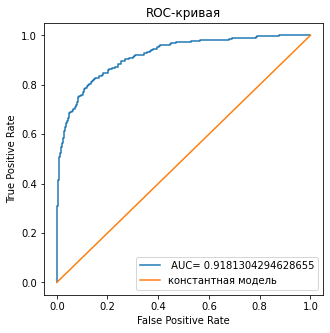

In [ ]:
y_pred_proba = best_model.predict_proba(features_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
y_half = np.ones(features_test.shape[0])*0.5
fpr_half, tpr_half, _ = metrics.roc_curve(y_test, y_half)

plt.plot(fpr,tpr, label=" AUC= "+str(roc_auc_score(y_test, predictions)))
plt.plot(fpr_half,tpr_half, label='константная модель' )
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc=4)
plt.show()

Как можем заметить, наша модель показывает намного лучше результаты, чем модель, у которой вероятности предсказания каждого значения равняется 50%.

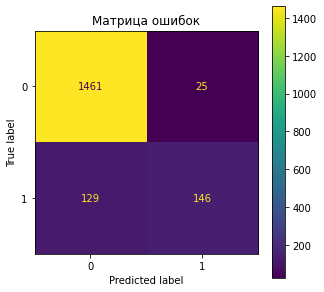

In [ ]:
#r = np.flip(metrics.confusion_matrix(y_test, predictions), axis=0)
#display_labels = [False, True]
r = confusion_matrix(y_test, best_model.predict(features_test))
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = r, display_labels = best_model.classes_)
cm_display.plot()
plt.title('Матрица ошибок')
plt.show()

In [ ]:
print('Precision:', metrics.precision_score(y_test, best_model.predict(features_test)))
print('Recall:', metrics.recall_score(y_test, best_model.predict(features_test)))

Precision: 0.8538011695906432
Recall: 0.5309090909090909


По матрице ошибок можно заметить, что модель чаще ошибается в предсказание, что клиент останется, хотя на самом деле это не так.

Также заметим, что метрика precision имеет высокое значение, потому что наша модель хорошо определяет сколько из предсказанных клиентов, которые покинут компанию, действительно это сделают.

Полнота показывает нам, что около половины клиентов, которые ушли, мы выявили.

Посмотрим на важность признаков

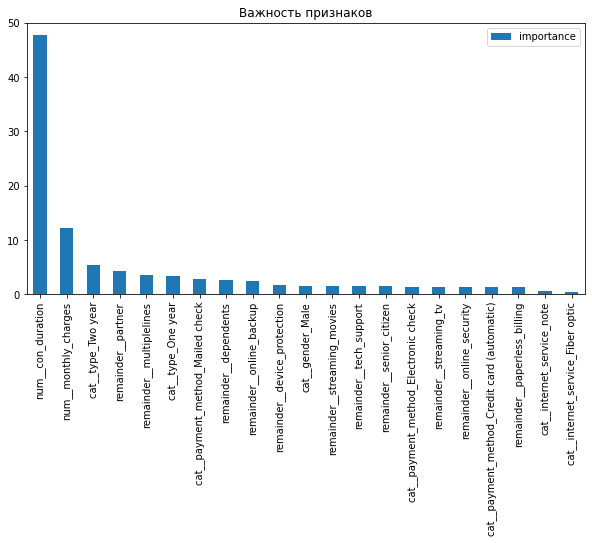

In [ ]:
pd.DataFrame(best_model._final_estimator.feature_importances_, index = model_result['CatBoostClassifier'].best_estimator_.named_steps.preprocessor.get_feature_names_out(), columns=['importance']).sort_values(by='importance', ascending=False)\
.plot(kind='bar', figsize=(10, 5), title='Важность признаков')
plt.show()

Теперь наглядно можно заметить, как признаки вляют на целевую переменную. Так, самое большое влиянение имеет продолжительность контракта, а самое маленькое - метод подключения интернета.

## Вывод

Главной задачей этой работы было создание модели, прогнозирующей уход клиентов.
В ходе выполнения поставленной задачи были выяснено следующее:


(В исследовательской части)

- постепенно все меньше людей в соотношение с кол-вом новых пользователей покидают компанию.
- чаще всего компанию покидают те пользователи, тариф которых устанавливает оплату по месяцам.
- судя по проведенной корреляцией многие доп услуги (категориальные признаки) имеют очень маленькое влияние на то, уйдет пользователь или нет.


(Построение модели)

В качестве лучшей модели было выбрано решение в виде ансамбля деревьев (CatBoostClassifier). Данная модель с метриками (learning_rate=0.1, n_estimators=400) была получена с помощью GridSearchCV и достигла значения auc_roc примерно равное 0.918 на тестовой выборке. Также у модели метрика Precision равняется 0.85, что означает, что она очень редка ошибается, когда говорит, что клиент покинет компанию. Были выявлены зависимости между признаками и тем, уйдут ли клиенты, и выявлено, что большее влияния играет "продолжительность контракта" и "сумма месячной оплаты".

# Отчет

**Какие пункты плана были выполнены, а какие — нет. Почему?**

Удалось выполнить все задачи поставленного плана.



**Какие трудности возникли и как вы их преодолели?**

Большая трудность возникла с созданием новых признаков на основе имеющихся. Были предприняты неверные попытки, после замечания данный пункт был исправлен.

Также использяю catboost с gridsearch и pipeline, возникала ошибка (*catboosterror: 'data' is numpy array of floating point numerical type, it means no categorical features, but 'cat_features' parameter specifies nonzero number of categorical features* ) при передачи категориальных признаков, пыталась это сделать потому, что catboost может сам кодировать категориальные признаки. В итоге кодировку категориальных признаков произвела до передачи в модель. В чем могла быть моя ошибка? Читала, что такое возможно, если в данных, которые передавались, могло быть значение None (float), но пропуски вроде бы отсуствовали.

Была небольшая проблема при построении важности признаков, так как нужно было получить столбцы уже после кодирования. Часть кода выполнялась локально, а в тетрадке - нет. Решением стало обновить jupyter до версии как на локальной машине.

**Какие ключевые шаги в решении задачи вы выделили?**
Я могу выделить следующие шаги:
- объединение датасетов.
- получение целевого признака.
- до и после выделение целевой переменной провести аналитический анализ для понимания взаимосвязей признаков.
- провести обработку данных: избавиться от выбросов, заменить пропуски.
- создать новые признаки на основе имеющихся.
- посмотреть на корреляцию признаков и на основе ее удалить неинформативнные или те, которые приведут к утечке данных.
- посмотреть на распедления признаков, чтобы лучше понимать их структуру.
- разделить выборки на обучающую и тестовую, провести необходимую подгтовку: например, закодировать категориальные признаки, а также произвести масштабирования, исходя из распределния данных. Так как в нашем случае распределение численных признаков отличалось от нормального, то я произвела нормализацию данных с помощью minmaxscaler.
- с помощью gridsearch подобрать лучшие гиперпараметры на моделях catboost, lightgbm и logisticregression.
- по метрике auc-roc найти лучшую модель. Получить значение auc-roc на тестовой выборке лучшей модели.
- посмотреть на roc-кривую и сравнить насколько она лучше, чем константная модель.
<img src=https://raw.githubusercontent.com/dashavpav/photos/main/%D0%A1%D0%BD%D0%B8%D0%BC%D0%BE%D0%BA.PNG width="250">
- также можно проверить другие метрики: precision и recall, они дадут больше информации об работе модели.
- построить матрицу ошибок.
<img src=https://raw.githubusercontent.com/dashavpav/photos/main/%D0%A1%D0%BD%D0%B8%D0%BC%D0%BE%D0%BA3.PNG width="250">
- посмотреть на важность признаков и выяснить, какие оказывают большее влиянение на целевую переменную, а какие меньшее.
<img src=https://raw.githubusercontent.com/dashavpav/photos/main/%D0%A1%D0%BD%D0%B8%D0%BC%D0%BE%D0%BA2.PNG width="250">

**Какие признаки использовали для обучения модели и какая предобработка этих признаков была выполнена?**
Были использованы все признаки, кроме:
- EndDate и BeginDate. Из их разницы был получен признак con_duration (сколько клиент пользуется услугами компании), а из EndDate был получен целевой признак is_close (ушел клиент или нет).
- TotalCharges, так как у него возникла слишком высокая корреляция с признаком con_duration.

Над численным признаками (monthly_charges, con_duration) была проведена нормализация с помощью MinMaxScaler.

Над категориальными признаками (type, payment_method, internet_service, gender) было проведено кодирование OneHotEnconding.

**Какая ваша итоговая модель, какие у неё гиперпараметы и какое качество?**
Итоговая модель - CatBoostClassifier c гиперпараметрами: скорость обучения(learning_rate) - 0.1 и кол-во деревьев (n_estimators) - 400 и RANDOM_STATE=30723. Качество на тестовой выборке по метрике auc-roc - 0.918.